In [2]:
# check for bias and variance 
%pip install mlxtend --upgrade

# Data cleaning

In [3]:
!pip3 install pickle5
import pickle5 as pickle
import json
import warnings
warnings.filterwarnings('ignore')

def load_data(path):
    with open(path, 'rb') as handle:
        dataset = pickle.load(handle)
    return dataset


def load_json(load_path):
    # read from path
    with open(load_path) as json_file:
        data = json.load(json_file)
    return data

In [4]:
train_set = load_data("/content/drive/MyDrive/dmr/data/clean_data2.pkl")
train_set.value_counts("sentiment")

sentiment
1    2024
2    1547
0    1193
dtype: int64

In [5]:
import re
import string

class CleanText:
    def __init__(self):
        self.stopwords = load_json("/content/drive/MyDrive/dmr/data/stopwords_nl.json")
    
    def clean_stopwords(self, content):
        # content: str
        content = content.split(" ")
        filtered_list = []
        stopwords = self.stopwords
        for word in content:
            if word not in stopwords:
                filtered_list.append(word)

        text = ' '.join(filtered_list)
        return text
    
    def remove_emoji(self, string):
        emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string)
    
    #  cleaning punctuation
    def clean_punctuation(self, content):
        #regex = re.compile('[%s]' % re.escape(string.punctuation))
        #content = regex.sub(" ", content)
        content = content.translate(content.maketrans("", "", string.punctuation))
        return content
    
    #  cleaning digits
    def clean_numbers(self, content):
        remove_digits = str.maketrans('', '', string.digits)
        text = content.translate(remove_digits)
        return text
    
    #  cleaning e-mails
    def clean_email(self, content):
        reg_email='\S*@\S*\s?'
        pattern_email = re.compile(reg_email)
        content = pattern_email.sub('',content)
        return content

    # clean links, hastag and mentions
    def clean_content(self, text):
        text = self.clean_email(text)
        text = re.sub("@[A-Za-z0-9_]+"," ", text)
        text = re.sub("#[A-Za-z0-9_]+"," ", text)
        text = re.sub(r'http\S+', ' ', text)
        text = re.sub(r'www\S+', ' ', text)
        text = text.replace('RT', ' ')
        text = text.replace('\n', ' ')
        text = text.replace('\t', ' ')
        text = self.clean_stopwords(text)
        text = self.remove_emoji(text)
        text = self.clean_punctuation(text)
        text = self.clean_numbers(text)

        filtered_sentence = []
        for word in text.split(" "):
            if len(word) > 1:
                word = word.strip()
                filtered_sentence.append(word)
        
        text = ' '.join(filtered_sentence)
        return text

In [6]:
cleaner = CleanText()
cleaning = lambda x: cleaner.clean_content(x)
train_set['clean_content_TFIDF'] = train_set['clean_content'].apply(cleaning)
train_set

,clean_content,sentiment,clean_content_TFIDF
0,Een dorsmachine wordt gebruikt voor het dorsen...,1,Een dorsmachine gebruikt dorsen ofwel oogsten ...
1,"De plant groeit vanuit een flinke bol,eerst on...",1,De plant groeit flinke boleerst ontstaan zomer...
2,"Als de temperatuur boven het vriespunt komt, k...",1,Als temperatuur vriespunt komt katjes openbrek...
3,Wie zijn er nog meer aanwezig? – Lowieke van R...,1,Wie aanwezig – Lowieke van River Marnemoende –...
4,Tot slot nog een vooraanzicht van de hele kaps...,1,Tot slot vooraanzicht hele kapschuur Op rek ho...
...,...,...,...
4826,Heb Ik Corona Of Zijn Mijn Longen Gewoon Boos ...,0,Heb Ik Corona Of Zijn Mijn Longen Gewoon Boos ...
4827,Nee Jaap. Jij reageert op een artikel van een ...,0,Nee Jaap Jij reageert artikel journalist toon ...
4828,Dit maakt het helemaal belachelijk,0,Dit helemaal belachelijk
4829,Ondernemers Baarle luiden corona-noodbel in pe...,0,Ondernemers Baarle luiden coronanoodbel petiti...


# Feature Extracting

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

#  word vectorizer and fit
vectorizer_word = TfidfVectorizer(max_features=1000, analyzer='word', ngram_range = (1,3), min_df=3, sublinear_tf=1)
featured_tfidf_word = vectorizer_word.fit(train_set['clean_content_TFIDF'])

#  save word vectorize
with open("/content/drive/MyDrive/dmr/data/clean_word_vectorizer.pkl", 'wb') as handle:
    pickle.dump(featured_tfidf_word, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("word feature extracted")

#  char vectorizer and fit the data
vectorizer_char = TfidfVectorizer(max_features=1000, analyzer='char', ngram_range = (2,6), sublinear_tf=True, min_df=3)
featured_tfidf_char = vectorizer_char.fit(train_set['clean_content_TFIDF'])
print("char feature extracted")

#  save char vectorizer
with open("/content/drive/MyDrive/dmr/data/clean_char_vectorizer.pkl", 'wb') as handle:
    pickle.dump(featured_tfidf_char, handle, protocol=pickle.HIGHEST_PROTOCOL)

word feature extracted
char feature extracted


# Feature extracting

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_set['clean_content'], train_set['sentiment'], random_state=55, test_size=0.3)
X_test, X_val, y_test, y_val  = train_test_split(X_test, y_test, random_state=55, test_size=0.5)

In [10]:
train_tf_word_transformed = featured_tfidf_word.transform(X_train)
train_tf_char_transformed = featured_tfidf_char.transform(X_train)

test_tf_word_transformed = featured_tfidf_word.transform(X_test)
test_tf_char_transformed = featured_tfidf_char.transform(X_test)

tf_train_features = hstack([train_tf_word_transformed, train_tf_char_transformed])
tf_train_features.shape

(3334, 2000)

# Train

In [11]:
class TrainModels:
    def __init__(self) -> None:
        self.svm = SVC(kernel='linear', gamma='auto')
        self.log_reg = LogisticRegression(random_state=0)
        self.gaussian = GaussianNB()
        self.complement = ComplementNB()
        self.knn = KNeighborsClassifier(n_neighbors=3)
        self.randon_forest = RandomForestClassifier()
    
    def train_models(self):
        svm_model = self.svm.fit(tf_train_features, y_train)
        print("SVM model trained")
        log_reg_model = self.log_reg.fit(tf_train_features, y_train)
        print("LogisticRegression model trained")
        gaussian_model = self.gaussian.fit(tf_train_features.todense(), y_train)
        print("GaussianNB model trained")
        complement_model = self.complement.fit(tf_train_features, y_train)
        print("ComplementNB model trained")
        knn_model = self.knn.fit(tf_train_features.todense(), y_train)
        print("KNeighborsClassifier model trained")
        random_forest_model = self.randon_forest.fit(tf_train_features.todense(), y_train)
        print("RandomForestClassifier model trained")

        return svm_model, log_reg_model, gaussian_model, complement_model, knn_model, random_forest_model


In [12]:
trainer = TrainModels()
models = trainer.train_models()

SVM model trained
LogisticRegression model trained
GaussianNB model trained
ComplementNB model trained
KNeighborsClassifier model trained
RandomForestClassifier model trained


# Evaluation

In [13]:
#  stack word and char tfidf features for evaluation
tf_test_featured = hstack([test_tf_word_transformed, test_tf_char_transformed])

for model in models:
    if str(model) in ["GaussianNB()", "ComplementNB()"]:
        train_acc = model.score(tf_test_featured.todense(), y_test)
        print(f"{str(round(train_acc * 100,2))}% accuracy ===> {str(model)}")
    else:
        train_acc = model.score(tf_test_featured, y_test)
        print(f"{str(round(train_acc * 100,2))}% accuracy ===> {str(model)}")

73.01% accuracy ===> SVC(gamma='auto', kernel='linear')
72.73% accuracy ===> LogisticRegression(random_state=0)
59.3% accuracy ===> GaussianNB()
67.41% accuracy ===> ComplementNB()
64.9% accuracy ===> KNeighborsClassifier(n_neighbors=3)
75.66% accuracy ===> RandomForestClassifier()


In [14]:
from mlxtend.evaluate import bias_variance_decomp
for model in models:
# estimate bias and variance
    mse, bias, var = bias_variance_decomp(model, tf_train_features.toarray(), y_train.values, tf_test_featured.toarray(), y_test.values, loss='0-1_loss', num_rounds=200, random_seed=1)
    # summarize results
    print(model)
    print('MSE: %.3f' % mse)
    print('Bias: %.3f' % bias)
    print('Variance: %.3f' % var)
    print('\n')

SVC(gamma='auto', kernel='linear')
MSE: 0.302
Bias: 0.266
Variance: 0.157


LogisticRegression(random_state=0)
MSE: 0.299
Bias: 0.273
Variance: 0.133


GaussianNB()
MSE: 0.411
Bias: 0.393
Variance: 0.182


ComplementNB()
MSE: 0.328
Bias: 0.317
Variance: 0.086


KNeighborsClassifier(n_neighbors=3)
MSE: 0.392
Bias: 0.344
Variance: 0.239


RandomForestClassifier()
MSE: 0.287
Bias: 0.243
Variance: 0.158




In [24]:
for model in models:
    #  save model
    filename = f"/content/drive/MyDrive/dmr/model/{str(model)}.sav"
    pickle.dump(model, open(filename, 'wb'))

## Let's test on validation data

In [16]:
# predict one by one for visualize prediction perform
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

predictions = []
for model in models:
    current_pred = {
        "model_name": str(model),
        "predictions": []
    }
    for single_data in X_val:
        clean_single_data = cleaner.clean_content(single_data)
        word_transformed_news = featured_tfidf_word.transform([clean_single_data])
        char_transformed_news = featured_tfidf_char.transform([clean_single_data])
        featured_data = hstack([word_transformed_news, char_transformed_news])
        if str(model) in ["GaussianNB()", "ComplementNB()"]:
            current_pred["predictions"].append(model.predict(featured_data.todense())[0])
        else:
            current_pred["predictions"].append(model.predict(featured_data.toarray())[0])
    predictions.append(current_pred)


In [23]:
models[3].predict(featured_data.todense())

array([2])

In [17]:
#  calculate accuracy on validation data
for pred in predictions:
    print(f"Accuracy of {pred['model_name']} is:", round(accuracy_score(y_val, pred['predictions'])*100,2))

Accuracy of SVC(gamma='auto', kernel='linear') is: 66.99
Accuracy of LogisticRegression(random_state=0) is: 67.69
Accuracy of GaussianNB() is: 58.88
Accuracy of ComplementNB() is: 65.17
Accuracy of KNeighborsClassifier(n_neighbors=3) is: 52.73
Accuracy of RandomForestClassifier() is: 65.59


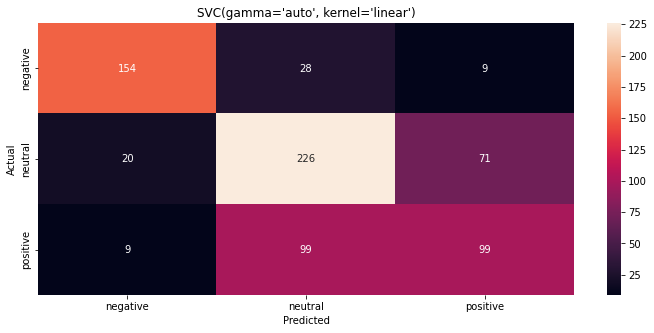

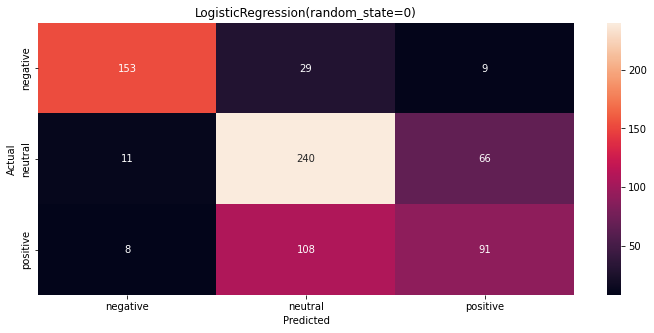

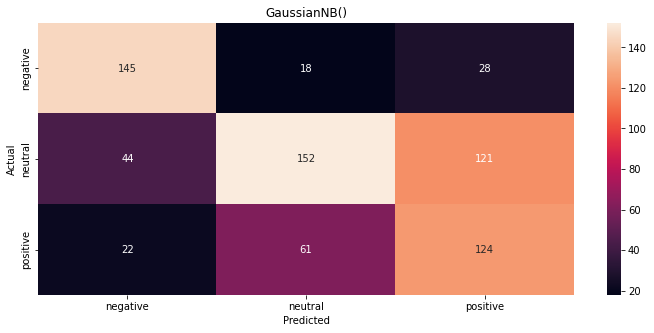

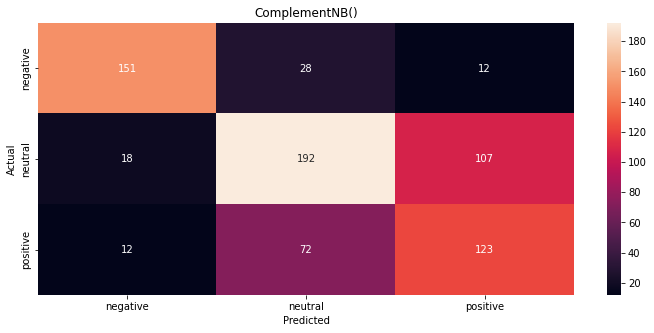

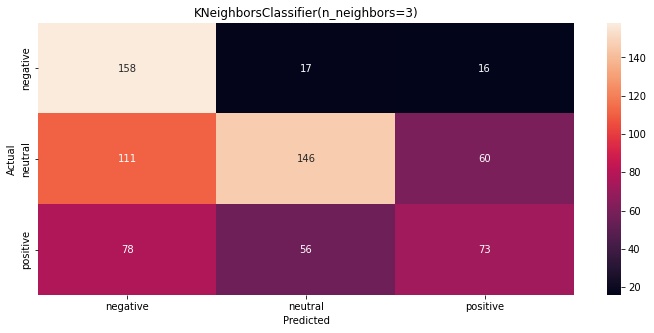

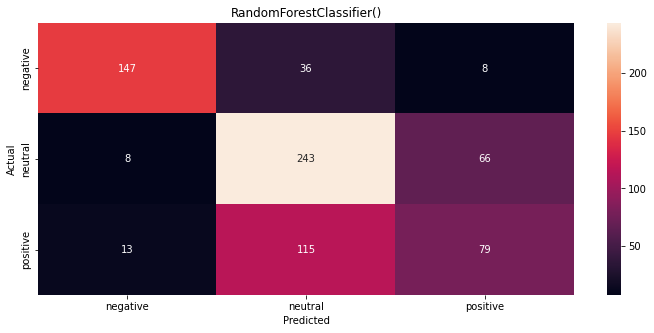

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

targets = ["negative", "neutral", "positive"]

for pred in predictions:
    conf_mat = confusion_matrix(y_val, pred['predictions'])
    fig, ax = plt.subplots(figsize=(12,5))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=targets, yticklabels=targets)
    plt.title(pred['model_name'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [19]:
for pred in predictions:
    print(pred['model_name'])
    print(classification_report(y_val, pred['predictions'], target_names=targets))
    print('\n')

SVC(gamma='auto', kernel='linear')
              precision    recall  f1-score   support

    negative       0.84      0.81      0.82       191
     neutral       0.64      0.71      0.67       317
    positive       0.55      0.48      0.51       207

    accuracy                           0.67       715
   macro avg       0.68      0.67      0.67       715
weighted avg       0.67      0.67      0.67       715



LogisticRegression(random_state=0)
              precision    recall  f1-score   support

    negative       0.89      0.80      0.84       191
     neutral       0.64      0.76      0.69       317
    positive       0.55      0.44      0.49       207

    accuracy                           0.68       715
   macro avg       0.69      0.67      0.67       715
weighted avg       0.68      0.68      0.67       715



GaussianNB()
              precision    recall  f1-score   support

    negative       0.69      0.76      0.72       191
     neutral       0.66      0.48      0.5